In [1]:
#pip install sciunit quantities efel scipy json2html neurom

In [2]:
#% matplotlib notebook
% matplotlib inline
from json2html import *
from quantities import mV, nA, ms, V, s
import IPython
import json
import collections

#import sciunit
from hippounit import models
from hippounit import tests
#from hippounit import capabilities

import matplotlib.pyplot as plt

from neuron import h
import math

In [3]:
# Load target data
#observation=json.load(open('oblique_target_data.json'))

with open('oblique_target_data.json') as f:
    observation = json.load(f, object_pairs_hook=collections.OrderedDict)

IPython.display.HTML(json2html.convert(json = observation))

mean_threshold,3.4*mV
threshold_sem,0.2*mV
exp_n,92
mean_prox_threshold,4.5*mV
prox_threshold_sem,0.5*mV
prox_n,33
mean_dist_threshold,2.6*mV
dist_threshold_sem,0.2*mV
dist_n,44
mean_nonlin_at_th,142
nonlin_at_th_sem,9


In [4]:
#To make it possible to calculate with data including quantities
for key, value in observation.iteritems():
    observation[key] = eval(value)
    

In [5]:
# Calculate experimental standard deviations and add to observation
observation["threshold_std"]=float(observation["threshold_sem"]*math.sqrt(observation["exp_n"]))*mV
observation["prox_threshold_std"]=float(observation["prox_threshold_sem"]*math.sqrt(observation["prox_n"]))*mV
observation["dist_threshold_std"]=float(observation["dist_threshold_sem"]*math.sqrt(observation["dist_n"]))*mV
observation["nonlin_at_th_std"]=float(observation["nonlin_at_th_sem"]*math.sqrt(observation["exp_n"]))
observation["nonlin_suprath_std"]=float(observation["nonlin_suprath_sem"]*math.sqrt(observation["exp_n"]))
observation["peak_deriv_std"]=float(observation["peak_deriv_sem"]*math.sqrt(observation["exp_n"]))*V /s
observation["amp_at_th_std"]=float(observation["amp_at_th_sem"]*math.sqrt(observation["exp_n"]))*mV
observation["time_to_peak_std"]=float(observation["time_to_peak_sem"]*math.sqrt(observation["exp_n"]))*ms
observation["async_nonlin_std"]=float(observation["async_nonlin_sem"]*math.sqrt(observation["async_n"]))


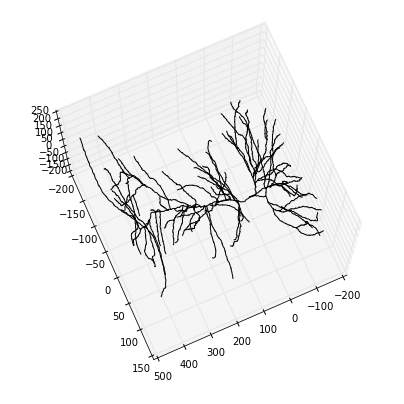

'\nfrom neurom import load_neuron\nfrom neurom import viewer\nmorph_path = "/home/osboxes/bsp_data_repository-master/optimizations/CA1_pyr_cAC_12AUG16/morphology/dend-050921AM2_axon-051208AM2.asc"\nviewer.draw(load_neuron(morph_path));\n'

In [6]:
#Load and visualize cell model

model = models.Model()

# outputs will be saved in folders named like this:
model.name="Kali_new_dendrite_NMDA_JSmodositott_0_4"

# path to mod files
model.modelpath = "./hippounit/models/hoc_models/Kali_Freund_modell/scppinput/"

# if this doesn't exist mod files are automatically compiled
model.libpath = "x86_64/.libs/libnrnmech.so.0"

# path to hoc file
# the model must not display any GUI!!
model.hocpath = "./hippounit/models/hoc_models/Kali_Freund_modell/scppinput/ca1_syn_NaBG_KDRS4_params_voltage_dep_AXON_Bianchi_KM2_params_DENDRITE_NO_GUI.hoc"

# If the hoc file doesn't contain a template, this must be None
model.template_name = None

# should be None, if there is no Section List in the model for the soma
model.SomaSecList_name = None

# if the soma is not in a section list, add its name here:
model.soma = 'soma'


model.load_mod_files() #This automatically compiles mod files, if they are not yet compiled
model.initialise() # Loads the model, creates stand alone cell from template. 
# uses the soma section list to set the location of somatic stimuli (and measurement)
# If the given section list contains more elements, the last one is used

# use this to visualize hoc morphology
from PyNeuronToolbox.morphology import shapeplot
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(7,7))
shapeax = plt.subplot(111, projection='3d')
shapeax.view_init(75,66)
shapeplot(h,shapeax)
plt.show()

'''
from neurom import load_neuron
from neurom import viewer
morph_path = "/home/osboxes/bsp_data_repository-master/optimizations/CA1_pyr_cAC_12AUG16/morphology/dend-050921AM2_axon-051208AM2.asc"
viewer.draw(load_neuron(morph_path));
'''

In [7]:
# The model tested must contain SectionLists containing the sections of the trunk and oblique dendrites
model.ObliqueSecList_name = 'oblique_dendrites'
model.TrunkSecList_name = 'trunk'

# according to the experiment the distance of the obliques tested from the trunk sould be max. 120 microns
# but the cell may not have enough obliques this close that meet all the other criteria: originate from the trunk, have no child, close to soma
model.max_dist_from_soma = 180  

# Automatically chooses the oblique dendrites and locations to be stimulated during the test based on the section lists
model.find_good_obliques()

AttributeError: 'hoc.HocObject' object has no attribute 'oblique_dendrites'

In [ ]:
#all the outputs will be saved here
base_directory = '/home/osboxes/BBP_project/150904_neuronunit/neuronunit/'


# Set the test
#The vectors of the somatic and dendritic voltage values are saved in files during the simulation. 
#If force_run=False, and the files already exist, the test uses the saved files for further calculations 
#If force_run=True, or the files don't exist, the test runs the whole simulation.
show_plot=True
test = tests.ObliqueIntegrationTest(observation, force_run_synapse=False, force_run_bin_search=False, base_directory=base_directory, show_plot=show_plot)


# Set the number of processes running parallel
import multiprocessing
test.npool = multiprocessing.cpu_count() - 1

In [ ]:
# Run the test
# Call SciUnit's judge function. 
#This calls the generate_prediction function of the test to generate prediction (data of model behaviour)
#Also calls the compute_score function of the test to calculate the error
score = test.judge(model)

In [ ]:
# Visualize model feature values in a table
for key, value in score.prediction.iteritems():
		score.prediction[key] = str(value)
               
IPython.display.HTML(json2html.convert(json = score.prediction))

In [ ]:
#Summarize and print the score achieved by the model on the test using SciUnit's summarize function
score.summarize()